In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import rioxarray as rxr
import xarray as xr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import os
from pathlib import Path

In [11]:

# setup: Ensure correct working directory
print("Setting up working directory...")

current_dir = Path.cwd()
target_dir = None

# check if we're already in the right place
if current_dir.name == "scripts" and current_dir.parent.name == "CHAR":
    print(f"✓ Already in correct directory: {current_dir}")
    target_dir = current_dir
else:
    # Find CHAR directory
    for check_dir in [current_dir, current_dir / "CHAR"] + [p / "CHAR" for p in current_dir.parents]:
        if check_dir.name == "CHAR" and check_dir.exists():
            scripts_path = check_dir / "scripts"
            if scripts_path.exists():
                os.chdir(scripts_path)
                target_dir = scripts_path
                print(f"✓ Changed to: {scripts_path}")
                break
    
    if target_dir is None:
        print("✗ Could not find CHAR/scripts directory")
        print("Please make sure you're running this from within a CHAR project directory")
        raise FileNotFoundError("CHAR/scripts directory not found")

# Verify we can access the data
data_path = Path("../downloaded_data/mnf_fires_all.geojson")
if not data_path.exists():
    print(f"Cannot find fire data at: {data_path.resolve()}")
    print("Please check your directory structure")
else:
    print(f"Found fire data at: {data_path.resolve()}")

# Load the data
#fires = gpd.read_file("../downloaded_data/mnf_fires_all.geojson")

Setting up working directory...
✓ Already in correct directory: /home/jovyan/CHAR/scripts
Found fire data at: /home/jovyan/CHAR/downloaded_data/mnf_fires_all.geojson


In [3]:
#!pip install stackstac --quiet

In [12]:
fires = gpd.read_file("../downloaded_data/mnf_fires_all.geojson")

# Step-by-step fix that handles any data type issues
print("Fixing FIRE_YEAR column...")

# Method 1: Convert each value individually
def safe_year_conversion(value):
    """Safely convert any value to integer year"""
    try:
        if pd.isna(value):
            return None
        # Handle string dates like "2020-01-01" -> 2020
        if isinstance(value, str) and '-' in value:
            return int(value.split('-')[0])
        # Handle floats like 2020.0 -> 2020
        return int(float(value))
    except:
        print(f"Could not convert value: {value} (type: {type(value)})")
        return None

# Apply the safe conversion
fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(safe_year_conversion)

# Remove rows where conversion failed
initial_count = len(fires)
fires = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
print(f"Kept {len(fires)} out of {initial_count} fires")

# Now use the clean column for date creation
fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR_CLEAN'].astype(int)

# Create dates using string formatting (this avoids the addition problem)
fires['pre_fire_date'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x}-04-15"))
fires['post_fire_1yr'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x+1}-07-01"))
fires['post_fire_2yr'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x+2}-07-01"))
fires['post_fire_5yr'] = fires['FIRE_YEAR_CLEAN'].apply(lambda x: pd.to_datetime(f"{x+5}-07-01"))

print("✓ Dates created successfully!")
print(f"Sample dates for first fire:")
sample = fires.iloc[0]
print(f"  Fire year: {sample['FIRE_YEAR_CLEAN']}")
print(f"  Pre-fire: {sample['pre_fire_date']}")
print(f"  1yr post: {sample['post_fire_1yr']}")

Fixing FIRE_YEAR column...
Kept 216 out of 216 fires
✓ Dates created successfully!
Sample dates for first fire:
  Fire year: 1910
  Pre-fire: 1910-04-15 00:00:00
  1yr post: 1911-07-01 00:00:00


Loading fire data...
Available years: [np.int64(1910), np.int64(1939), np.int64(1958), np.int64(1960), np.int64(1962), np.int64(1967), np.int64(1968), np.int64(1972), np.int64(1974), np.int64(1977), np.int64(1979), np.int64(1981), np.int64(1984), np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1994), np.int64(1995), np.int64(1996), np.int64(1997), np.int64(1998), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Found 2 fires from 1989

Selected Fire: Monument Rock (1989-ORWWF-000377)
Fire Year: 1989
Fire Area: 0.00575968 square degrees

Analysis Timeline:
Pre-fire (baseline): 1989-04-15
1 year post-fire: 1990-07-01



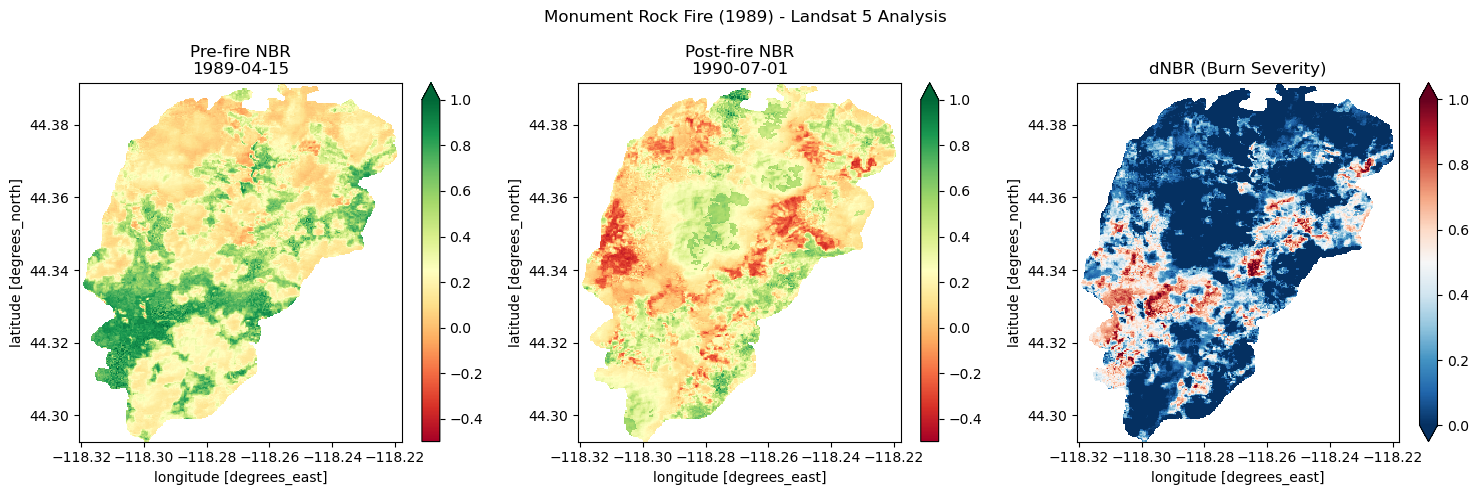

In [20]:
"""
Fire Severity Analysis using Landsat 5 NBR

This module analyzes wildfire burn severity using Normalized Burn Ratio (NBR) 
calculated from Landsat 5 satellite imagery.

Functions:
- clean_fire_year(): Converts fire year values to integers, handling various formats
- search_landsat5_imagery(): Searches for Landsat 5 images around a target date
- search_with_expanding_dates(): Searches with progressively wider date ranges
- calculate_nbr(): Computes NBR from Landsat 5 NIR and SWIR2 bands
- analyze_burn_severity(): Classifies burn severity from dNBR values
- run_fire_analysis(): Main workflow to analyze a single fire

Usage:
    python fire_severity.py
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def clean_fire_year(year_value):
    """Convert fire year to integer, handling strings and numbers."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None


def search_landsat5_imagery(geometry, target_date, days_buffer=30):
    """Search for Landsat 5 imagery around target date."""
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    print(f"Searching Landsat 5 imagery from {start_date} to {end_date}")
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    bounds = geometry.bounds
    bbox = [bounds[0], bounds[1], bounds[2], bounds[3]]
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": ["landsat-5"]},
            "eo:cloud_cover": {"lt": 50}
        }
    )
    
    items = list(search.items())
    
    if len(items) == 0:
        print("No images found with cloud filter, trying without...")
        search = catalog.search(
            collections=["landsat-c2-l2"],
            bbox=bbox,
            datetime=f"{start_date}/{end_date}",
            query={"platform": {"in": ["landsat-5"]}}
        )
        items = list(search.items())
    
    if len(items) > 0:
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"Found {len(sorted_items)} Landsat 5 images")
        for i, (item, cloud, date_diff, date_str) in enumerate(items_with_info[:3]):
            print(f"  Image {i+1}: {date_str}, {cloud:.1f}% clouds, {date_diff} days from target")
        
        return sorted_items
    else:
        print("No Landsat 5 images found")
        return []


def search_with_expanding_dates(geometry, target_date):
    """Search with progressively expanding date ranges."""
    buffers = [30, 60, 120, 240]
    
    for attempt, buffer in enumerate(buffers):
        print(f"Attempt {attempt + 1}: Searching with +/-{buffer} day buffer...")
        items = search_landsat5_imagery(geometry, target_date, days_buffer=buffer)
        
        if len(items) > 0:
            return items
            
        if attempt < len(buffers) - 1:
            print("No results, expanding search window...")
    
    print("No Landsat 5 imagery found even with expanded ranges")
    return []


def calculate_nbr(item, fire_polygon):
    """Calculate NBR from Landsat 5 data, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        print(f"Processing image from: {item.properties.get('datetime', 'Unknown')}")
        print(f"Cloud cover: {item.properties.get('eo:cloud_cover', 'Unknown')}%")
        
        # Find NIR and SWIR2 bands
        nir_band = None
        swir2_band = None
        
        for asset_name in signed_item.assets.keys():
            if asset_name in ['B04', 'nir08']:
                nir_band = asset_name
            elif asset_name in ['B07', 'swir22']:
                swir2_band = asset_name
        
        if nir_band is None or swir2_band is None:
            print(f"Could not find required bands. NIR: {nir_band}, SWIR2: {swir2_band}")
            return None
        
        print(f"Using NIR band: {nir_band}, SWIR2 band: {swir2_band}")
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire polygon to raster CRS and crop
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        bounds = fire_proj.bounds
        crop_buffer = 2000
        
        try:
            nir_cropped = nir.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
            swir2_cropped = swir2.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
        except:
            print("Cropping failed, using original extent")
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Clip to fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        # Check results
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        total_pixels = nbr_fire_only.size
        
        print(f"Valid pixels: {valid_pixels}/{total_pixels} ({100*valid_pixels/total_pixels:.1f}%)")
        
        if valid_pixels == 0:
            print("No valid data within fire boundary")
            return None
        
        print("NBR calculated successfully")
        return nbr_fire_only
        
    except Exception as e:
        print(f"Error calculating NBR: {e}")
        return None


def analyze_burn_severity(dnbr_values):
    """Classify burn severity from dNBR values."""
    high_severity = np.sum(dnbr_values > 0.66)
    mod_high_severity = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low_severity = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low_severity = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total_pixels = len(dnbr_values)
    
    return {
        'high_severity': high_severity,
        'mod_high_severity': mod_high_severity,
        'mod_low_severity': mod_low_severity,
        'low_severity': low_severity,
        'unburned': unburned,
        'total_pixels': total_pixels
    }


def run_fire_analysis():
    """Main workflow to analyze fire burn severity."""
    print("Loading fire data...")
    fires = gpd.read_file("../downloaded_data/mnf_fires_all.geojson")
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    
    print(f"Available years: {sorted(fires_clean['FIRE_YEAR_CLEAN'].unique())}")
    
    # Filter for 1989 fires
    fires_1989 = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == 1989].copy()
    print(f"Found {len(fires_1989)} fires from 1989")
    
    if len(fires_1989) == 0:
        print("No 1989 fires found. Trying nearby years...")
        for test_year in [1988, 1990, 1987, 1991]:
            test_fires = fires_clean[fires_clean['FIRE_YEAR_CLEAN'] == test_year]
            if len(test_fires) > 0:
                print(f"Using {test_year} fires for testing ({len(test_fires)} fires)")
                fires_1989 = test_fires.copy()
                break
    
    if len(fires_1989) == 0:
        print("No fires found in dataset")
        return
    
    # Select first fire and convert to WGS84
    fires_1989_wgs84 = fires_1989.to_crs('EPSG:4326')
    test_fire = fires_1989_wgs84.iloc[0]
    fire_geom = test_fire.geometry
    fire_id = test_fire.get("UNQE_FIRE_", "unknown")
    incident = test_fire.get("INCIDENT", "unknown")
    fire_year = int(test_fire["FIRE_YEAR_CLEAN"])
    
    print(f"\nSelected Fire: {incident} ({fire_id})")
    print(f"Fire Year: {fire_year}")
    print(f"Fire Area: {fire_geom.area:.8f} square degrees")
    
    # Define analysis dates
    pre_fire_date = pd.to_datetime(f"{fire_year}-04-15")
    post_fire_1yr = pd.to_datetime(f"{fire_year + 1}-07-01")
    
    print(f"\nAnalysis Timeline:")
    print(f"Pre-fire (baseline): {pre_fire_date.strftime('%Y-%m-%d')}")
    print(f"1 year post-fire: {post_fire_1yr.strftime('%Y-%m-%d')}")
    
    # Search for pre-fire imagery
    print(f"\n1. Searching for pre-fire imagery...")
    pre_fire_items = search_with_expanding_dates(fire_geom, pre_fire_date)
    
    if len(pre_fire_items) == 0:
        print("No pre-fire imagery found")
        return
    
    # Calculate pre-fire NBR
    print(f"\n2. Calculating pre-fire NBR...")
    pre_fire_nbr = calculate_nbr(pre_fire_items[0], fire_geom)
    
    if pre_fire_nbr is None:
        print("Failed to calculate pre-fire NBR")
        return
    
    pre_stats = pre_fire_nbr.compute()
    print(f"Pre-fire NBR: Mean {float(pre_stats.mean().values):.3f}")
    
    # Search for post-fire imagery
    print(f"\n3. Searching for post-fire imagery...")
    post_fire_items = search_with_expanding_dates(fire_geom, post_fire_1yr)
    
    if len(post_fire_items) == 0:
        print("No post-fire imagery found")
        return
    
    # Calculate post-fire NBR
    print(f"\n4. Calculating post-fire NBR...")
    post_fire_nbr = calculate_nbr(post_fire_items[0], fire_geom)
    
    if post_fire_nbr is None:
        print("Failed to calculate post-fire NBR")
        return
    
    post_stats = post_fire_nbr.compute()
    print(f"Post-fire NBR: Mean {float(post_stats.mean().values):.3f}")
    
    # Calculate dNBR
    print(f"\n5. Calculating dNBR...")
    
    if pre_fire_nbr.rio.crs != post_fire_nbr.rio.crs:
        post_fire_nbr = post_fire_nbr.rio.reproject_match(pre_fire_nbr)
    
    dnbr = pre_fire_nbr - post_fire_nbr
    dnbr_computed = dnbr.compute()
    dnbr_flat = dnbr_computed.values.flatten()
    dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
    
    if len(dnbr_flat) == 0:
        print("No valid dNBR values calculated")
        return
    
    # Analyze burn severity
    severity_results = analyze_burn_severity(dnbr_flat)
    
    # Display results
    print(f"\nLANDSAT 5 ANALYSIS RESULTS")
    print(f"Fire: {incident} ({fire_id}), Year: {fire_year}")
    print(f"Satellite: Landsat 5 (30m resolution)")
    print(f"Analysis Period: {pre_fire_date.strftime('%Y-%m-%d')} to {post_fire_1yr.strftime('%Y-%m-%d')}")
    
    print(f"\nNBR Statistics (Fire Boundary Only):")
    print(f"Pre-fire NBR  - Mean: {float(pre_stats.mean().values):.3f}")
    print(f"Post-fire NBR - Mean: {float(post_stats.mean().values):.3f}")
    print(f"dNBR          - Mean: {np.mean(dnbr_flat):.3f}, Range: {np.min(dnbr_flat):.3f} to {np.max(dnbr_flat):.3f}")
    
    total = severity_results['total_pixels']
    print(f"\nBurn Severity Classification ({total} pixels):")
    print(f"High Severity (>0.66):      {severity_results['high_severity']:5d} pixels ({100*severity_results['high_severity']/total:5.1f}%)")
    print(f"Moderate-High (0.44-0.66):  {severity_results['mod_high_severity']:5d} pixels ({100*severity_results['mod_high_severity']/total:5.1f}%)")
    print(f"Moderate-Low (0.25-0.44):   {severity_results['mod_low_severity']:5d} pixels ({100*severity_results['mod_low_severity']/total:5.1f}%)")
    print(f"Low Severity (0.1-0.25):    {severity_results['low_severity']:5d} pixels ({100*severity_results['low_severity']/total:5.1f}%)")
    print(f"Unburned (<0.1):            {severity_results['unburned']:5d} pixels ({100*severity_results['unburned']/total:5.1f}%)")
    
    print(f"\nAnalysis complete for {fire_year} fire!")
    
    # Create visualization
    try:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        pre_geo = pre_fire_nbr.rio.reproject('EPSG:4326')
        post_geo = post_fire_nbr.rio.reproject('EPSG:4326')
        dnbr_geo = dnbr.rio.reproject('EPSG:4326')
        
        pre_geo.plot(ax=axes[0], cmap='RdYlGn', vmin=-0.5, vmax=1.0)
        post_geo.plot(ax=axes[1], cmap='RdYlGn', vmin=-0.5, vmax=1.0)
        dnbr_geo.plot(ax=axes[2], cmap='RdBu_r', vmin=0, vmax=1.0)
        
        axes[0].set_title(f'Pre-fire NBR\n{pre_fire_date.strftime("%Y-%m-%d")}')
        axes[1].set_title(f'Post-fire NBR\n{post_fire_1yr.strftime("%Y-%m-%d")}')
        axes[2].set_title('dNBR (Burn Severity)')
        
        plt.suptitle(f'{incident} Fire ({fire_year}) - Landsat 5 Analysis')
        plt.tight_layout()
        plt.show()
        
    except Exception as plot_error:
        print(f"Plotting failed: {plot_error}")


if __name__ == "__main__":
    run_fire_analysis()

In [8]:
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import plugins
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. LOAD AND PREPARE FIRE DATA (1985-1995)
# =============================================================================

print("Loading fire data for 1985-1995...")
fires = gpd.read_file("../downloaded_data/mnf_fires_all.geojson")

# Clean the FIRE_YEAR column (same as before)
def clean_fire_year(year_value):
    """Convert fire year to integer, handling strings and numbers"""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None

fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)

# Filter for 1985-1995 fires
fires_80s_90s = fires_clean[
    (fires_clean['FIRE_YEAR_CLEAN'] >= 1985) & 
    (fires_clean['FIRE_YEAR_CLEAN'] <= 1995)
].copy()

print(f"Found {len(fires_80s_90s)} fires from 1985-1995")
print(f"Years represented: {sorted(fires_80s_90s['FIRE_YEAR_CLEAN'].unique())}")

# Convert to WGS84 for mapping
fires_80s_90s_wgs84 = fires_80s_90s.to_crs('EPSG:4326')

# Add area in hectares for display
fires_80s_90s_wgs84['area_hectares'] = fires_80s_90s_wgs84.geometry.area * 111 * 111 * 100

# Clean up fire names and IDs for display
fires_80s_90s_wgs84['display_name'] = fires_80s_90s_wgs84['INCIDENT'].fillna('Unnamed Fire')
fires_80s_90s_wgs84['display_id'] = fires_80s_90s_wgs84['UNQE_FIRE_'].fillna('No ID')

print("\nFire summary by year:")
year_summary = fires_80s_90s_wgs84.groupby('FIRE_YEAR_CLEAN').agg({
    'display_name': 'count',
    'area_hectares': ['sum', 'mean']
}).round(1)
year_summary.columns = ['Count', 'Total_Area_ha', 'Mean_Area_ha']
print(year_summary)

# =============================================================================
# 2. CREATE INTERACTIVE MAP
# =============================================================================

def create_interactive_fire_map(fires_gdf, map_title="Malheur National Forest Fires (1985-1995)"):
    """Create an interactive map with fire polygons, names, and years"""
    
    # Calculate map center
    bounds = fires_gdf.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=9,
        tiles='OpenStreetMap'
    )
    
    # Add additional tile layers (with proper attributions)
    folium.TileLayer(
        tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
        attr='Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
        name='Topographic',
        overlay=False,
        control=True
    ).add_to(m)
    
    folium.TileLayer(
        tiles='CartoDB positron',
        name='Light Map'
    ).add_to(m)
    
    # Color palette for different years
    years = sorted(fires_gdf['FIRE_YEAR_CLEAN'].unique())
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'lightred', 
              'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue']
    year_colors = {year: colors[i % len(colors)] for i, year in enumerate(years)}
    
    # Add fires to map, grouped by year
    for year in years:
        year_fires = fires_gdf[fires_gdf['FIRE_YEAR_CLEAN'] == year]
        
        # Create a feature group for this year
        fg = folium.FeatureGroup(name=f'{year} Fires ({len(year_fires)})')
        
        for idx, fire in year_fires.iterrows():
            # Create popup with fire information
            popup_html = f"""
            <div style="width: 300px;">
                <h4>{fire['display_name']}</h4>
                <b>Year:</b> {fire['FIRE_YEAR_CLEAN']}<br>
                <b>Fire ID:</b> {fire['display_id']}<br>
                <b>Area:</b> {fire['area_hectares']:.1f} hectares<br>
                <b>Location:</b> {fire.geometry.centroid.y:.4f}°N, {fire.geometry.centroid.x:.4f}°W<br>
                <b>Original FIRE_YEAR:</b> {fire['FIRE_YEAR']}
            </div>
            """
            
            # Add fire polygon
            folium.GeoJson(
                fire.geometry,
                popup=folium.Popup(popup_html, max_width=350),
                tooltip=f"{fire['display_name']} ({fire['FIRE_YEAR_CLEAN']})",
                style_function=lambda feature, color=year_colors[year]: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 1,
                    'fillOpacity': 0.6
                }
            ).add_to(fg)
            
            # Add fire centroid marker with label
            folium.CircleMarker(
                location=[fire.geometry.centroid.y, fire.geometry.centroid.x],
                radius=5,
                popup=popup_html,
                tooltip=f"{fire['display_name']} ({fire['FIRE_YEAR_CLEAN']})",
                color='black',
                fillColor=year_colors[year],
                fillOpacity=0.8
            ).add_to(fg)
            
            # Add text label
            folium.Marker(
                location=[fire.geometry.centroid.y, fire.geometry.centroid.x],
                icon=folium.DivIcon(
                    html=f'<div style="font-size: 10pt; color: black; font-weight: bold; text-shadow: 1px 1px 1px white;">{fire["display_name"][:15]}</div>',
                    icon_size=(100, 20),
                    icon_anchor=(50, 10)
                )
            ).add_to(fg)
        
        fg.add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    # Add a custom legend
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>{map_title}</h4>
    <p><b>Fire Years & Colors:</b></p>
    '''
    
    for year in years:
        legend_html += f'<p><span style="color:{year_colors[year]};">●</span> {year}</p>'
    
    legend_html += '''
    <p><b>Click on fires for details</b></p>
    </div>
    '''
    
    m.get_root().html.add_child(folium.Element(legend_html))
    
    return m

# =============================================================================
# 3. CREATE AND DISPLAY THE MAP
# =============================================================================

print(f"\nCreating interactive map with {len(fires_80s_90s_wgs84)} fires...")

# Create the map
fire_map = create_interactive_fire_map(fires_80s_90s_wgs84)

# Save the map
map_filename = "malheur_fires_1985_1995_interactive.html"
fire_map.save(map_filename)

print(f"✓ Interactive map saved as: {map_filename}")
print(f"✓ Open this file in your web browser to explore the fires")

# =============================================================================
# 4. DISPLAY SUMMARY TABLE
# =============================================================================

print(f"\n" + "="*80)
print("FIRE SUMMARY TABLE (1985-1995)")
print("="*80)

# Create a summary table for easy reference
summary_table = fires_80s_90s_wgs84[['FIRE_YEAR_CLEAN', 'display_name', 'display_id', 'area_hectares']].copy()
summary_table['area_hectares'] = summary_table['area_hectares'].round(1)
summary_table = summary_table.sort_values(['FIRE_YEAR_CLEAN', 'area_hectares'], ascending=[True, False])

print("\nAll fires (sorted by year, then size):")
for year in sorted(summary_table['FIRE_YEAR_CLEAN'].unique()):
    year_fires = summary_table[summary_table['FIRE_YEAR_CLEAN'] == year]
    print(f"\n{year} ({len(year_fires)} fires):")
    for idx, fire in year_fires.iterrows():
        print(f"  • {fire['display_name']} ({fire['display_id']}) - {fire['area_hectares']:.1f} ha")

# =============================================================================
# 5. FUNCTION TO FILTER BY COORDINATES
# =============================================================================

def find_fires_in_area(fires_gdf, min_lon, min_lat, max_lon, max_lat):
    """Find fires within a specific geographic area"""
    
    area_fires = fires_gdf[
        (fires_gdf.geometry.centroid.x >= min_lon) &
        (fires_gdf.geometry.centroid.x <= max_lon) &
        (fires_gdf.geometry.centroid.y >= min_lat) &
        (fires_gdf.geometry.centroid.y <= max_lat)
    ]
    
    print(f"\nFires in area ({min_lon}, {min_lat}) to ({max_lon}, {max_lat}):")
    if len(area_fires) == 0:
        print("  No fires found in this area")
    else:
        for idx, fire in area_fires.iterrows():
            print(f"  • {fire['FIRE_YEAR_CLEAN']}: {fire['display_name']} ({fire['display_id']})")
            print(f"    Location: {fire.geometry.centroid.y:.4f}°N, {fire.geometry.centroid.x:.4f}°W")
            print(f"    Area: {fire['area_hectares']:.1f} hectares")
    
    return area_fires

print(f"\n" + "="*80)
print("USAGE INSTRUCTIONS")
print("="*80)
print("1. Open the saved HTML file in your web browser")
print("2. Click on fires to see detailed information")
print("3. Use layer control to show/hide fires by year")
print("4. Identify the fires from your collaborator's screenshot")
print("5. Note down the fire names and IDs")
print("\nTo filter by area, use:")
print("find_fires_in_area(fires_80s_90s_wgs84, min_lon, min_lat, max_lon, max_lat)")

# Example area filter (you can adjust coordinates based on screenshot)
print(f"\nExample - fires in central area:")
central_fires = find_fires_in_area(fires_80s_90s_wgs84, -119.2, 43.9, -118.7, 44.2)

Loading fire data for 1985-1995...
Found 44 fires from 1985-1995
Years represented: [np.int64(1986), np.int64(1987), np.int64(1988), np.int64(1989), np.int64(1990), np.int64(1991), np.int64(1992), np.int64(1994), np.int64(1995)]

Fire summary by year:
                 Count  Total_Area_ha  Mean_Area_ha
FIRE_YEAR_CLEAN                                    
1986                 6         2693.6         448.9
1987                 2          404.7         202.4
1988                 4          374.5          93.6
1989                 2        12341.2        6170.6
1990                13       122193.7        9399.5
1991                 2            6.7           3.3
1992                 1            0.1           0.1
1994                13        27209.8        2093.1
1995                 1          109.0         109.0

Creating interactive map with 44 fires...
✓ Interactive map saved as: malheur_fires_1985_1995_interactive.html
✓ Open this file in your web browser to explore the fires

FIRE 

In [31]:
"""
Multi-Fire Severity Analysis Module

Analyzes burn severity for multiple target fires using Landsat NBR data.

Functions:
- clean_fire_year(): Convert fire year values to integers
- find_target_fire(): Find specific fire by name, ID, year, and/or location
- search_landsat5_imagery(): Search for Landsat 5 images around target date
- search_with_expanding_dates(): Search with progressively wider date ranges
- calculate_nbr(): Calculate NBR from Landsat data
- analyze_fire_severity(): Calculate burn severity statistics
- analyze_multiple_fires(): Process multiple target fires
- create_summary_table(): Generate results summary

Usage:
    results = analyze_multiple_fires(geojson_path, target_fires_list)
"""

import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import pystac_client
import planetary_computer as pc
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


def clean_fire_year(year_value):
    """Convert fire year to integer, handling various formats."""
    try:
        if pd.isna(year_value):
            return None
        year_str = str(year_value)
        if '-' in year_str:
            return int(year_str.split('-')[0])
        return int(float(year_str))
    except (ValueError, TypeError):
        return None


def find_target_fire(fires_gdf, target_info):
    """Find a specific fire using name, and optionally year, ID, and/or location."""
    
    # If only name is provided, search across all years
    if 'year' in target_info:
        year_fires = fires_gdf[fires_gdf['FIRE_YEAR_CLEAN'] == target_info['year']]
    else:
        year_fires = fires_gdf
    
    # Try to match by fire ID first (most reliable)
    if target_info.get('fire_id') is not None:
        id_matches = year_fires[year_fires['UNQE_FIRE_'] == target_info['fire_id']]
        if len(id_matches) > 0:
            print(f"Found {target_info['name']} by Fire ID: {target_info['fire_id']}")
            return id_matches.iloc[0]
    
    # Try to match by name
    name_matches = year_fires[
        year_fires['INCIDENT'].str.contains(target_info['name'], case=False, na=False)
    ]
    
    if len(name_matches) > 0:
        if len(name_matches) == 1:
            fire = name_matches.iloc[0]
            print(f"Found {target_info['name']} by name match ({int(fire['FIRE_YEAR_CLEAN'])})")
            return fire
        else:
            # Multiple matches - show options or pick most recent
            print(f"Found {len(name_matches)} fires matching '{target_info['name']}':")
            for i, (idx, fire) in enumerate(name_matches.iterrows()):
                year = int(fire['FIRE_YEAR_CLEAN'])
                fire_id = fire.get('UNQE_FIRE_', 'No ID')
                area = fire.geometry.area * 111 * 111 * 100  # rough hectares
                print(f"  {i}: {fire['INCIDENT']} ({year}) - {area:.1f} ha - {fire_id}")
            
            # Return the most recent one
            most_recent = name_matches.loc[name_matches['FIRE_YEAR_CLEAN'].idxmax()]
            print(f"Using most recent: {most_recent['INCIDENT']} ({int(most_recent['FIRE_YEAR_CLEAN'])})")
            return most_recent
    
    # Try to match by location if provided
    if 'approx_location' in target_info:
        target_lat, target_lon = target_info['approx_location']
        location_tolerance = 0.05  # ~5km
        
        location_matches = year_fires[
            (abs(year_fires.geometry.centroid.y - target_lat) < location_tolerance) &
            (abs(year_fires.geometry.centroid.x - target_lon) < location_tolerance)
        ]
        
        if len(location_matches) > 0:
            print(f"Found {target_info['name']} by location match")
            # If multiple matches, pick the closest one
            distances = location_matches.geometry.centroid.apply(
                lambda pt: ((pt.y - target_lat)**2 + (pt.x - target_lon)**2)**0.5
            )
            closest_idx = distances.idxmin()
            return location_matches.loc[closest_idx]
    
    print(f"Could not find {target_info['name']}")
    return None


def search_landsat5_imagery(geometry, target_date, days_buffer=30):
    """Search for Landsat 5 imagery around target date."""
    
    start_date = (target_date - timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=days_buffer)).strftime('%Y-%m-%d')
    
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1/",
        modifier=pc.sign_inplace
    )
    
    bounds = geometry.bounds
    bbox = [bounds[0], bounds[1], bounds[2], bounds[3]]
    
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=f"{start_date}/{end_date}",
        query={
            "platform": {"in": ["landsat-5"]},
            "eo:cloud_cover": {"lt": 70}
        }
    )
    
    items = list(search.items())
    
    if len(items) > 0:
        # Sort by cloud cover and date proximity
        items_with_info = []
        for item in items:
            cloud_cover = item.properties.get('eo:cloud_cover', 100)
            item_date = pd.to_datetime(item.properties['datetime'])
            
            if item_date.tz is not None:
                item_date = item_date.tz_localize(None)
            if hasattr(target_date, 'tz') and target_date.tz is not None:
                target_date = target_date.tz_localize(None)
            
            date_diff = abs((item_date - target_date).days)
            items_with_info.append((item, cloud_cover, date_diff, item_date.strftime('%Y-%m-%d')))
        
        items_with_info.sort(key=lambda x: (x[2], x[1]))
        sorted_items = [item for item, cloud, date_diff, date_str in items_with_info]
        
        print(f"    Found {len(sorted_items)} images, best: {items_with_info[0][3]} ({items_with_info[0][1]:.1f}% clouds)")
        return sorted_items
    else:
        print(f"    No Landsat 5 images found")
        return []


def search_with_expanding_dates(geometry, target_date, fire_name=""):
    """Search with progressively expanding date ranges."""
    buffers = [30, 60, 120, 240]
    
    print(f"  Searching imagery for {fire_name}...")
    for attempt, buffer in enumerate(buffers):
        if attempt > 0:
            print(f"    Attempt {attempt + 1}: +/-{buffer} days...")
        items = search_landsat5_imagery(geometry, target_date, days_buffer=buffer)
        
        if len(items) > 0:
            return items
    
    print(f"    No imagery found for {fire_name}")
    return []


def calculate_nbr(item, fire_polygon, fire_name=""):
    """Calculate NBR from Landsat 5, clipped to fire boundary."""
    try:
        signed_item = pc.sign(item)
        
        # Find correct band names
        available_assets = list(signed_item.assets.keys())
        nir_band = None
        swir2_band = None
        
        for asset in ['B04', 'nir08', 'NIR']:
            if asset in available_assets:
                nir_band = asset
                break
                
        for asset in ['B07', 'swir22', 'SWIR2']:
            if asset in available_assets:
                swir2_band = asset
                break
        
        if nir_band is None or swir2_band is None:
            print(f"    Missing bands for {fire_name}. Available: {available_assets}")
            return None
        
        # Load bands
        nir = rxr.open_rasterio(signed_item.assets[nir_band].href, chunks={'x': 1024, 'y': 1024})
        swir2 = rxr.open_rasterio(signed_item.assets[swir2_band].href, chunks={'x': 1024, 'y': 1024})
        
        # Convert fire to raster CRS and crop
        temp_gdf = gpd.GeoDataFrame([1], geometry=[fire_polygon], crs='EPSG:4326')
        fire_proj = temp_gdf.to_crs(nir.rio.crs).geometry.iloc[0]
        bounds = fire_proj.bounds
        crop_buffer = 2000
        
        try:
            nir_cropped = nir.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
            swir2_cropped = swir2.rio.clip_box(
                minx=bounds[0] - crop_buffer, miny=bounds[1] - crop_buffer,
                maxx=bounds[2] + crop_buffer, maxy=bounds[3] + crop_buffer
            )
        except:
            nir_cropped = nir
            swir2_cropped = swir2
        
        # Apply Landsat Collection 2 scaling
        nir_scaled = nir_cropped * 0.0000275 - 0.2
        swir2_scaled = swir2_cropped * 0.0000275 - 0.2
        
        # Ensure same resolution
        if nir_scaled.shape != swir2_scaled.shape:
            swir2_scaled = swir2_scaled.rio.reproject_match(nir_scaled)
        
        # Calculate NBR
        nbr = (nir_scaled - swir2_scaled) / (nir_scaled + swir2_scaled)
        nbr = nbr.where((nir_scaled + swir2_scaled) != 0)
        
        # Clip to fire boundary
        nbr_fire_only = nbr.rio.clip([fire_proj], crs=nbr.rio.crs, drop=True, all_touched=True)
        
        valid_pixels = (~np.isnan(nbr_fire_only.values)).sum()
        
        if valid_pixels == 0:
            print(f"    No valid data for {fire_name}")
            return None
        
        print(f"    NBR calculated for {fire_name} ({valid_pixels} pixels)")
        return nbr_fire_only
        
    except Exception as e:
        print(f"    Error calculating NBR for {fire_name}: {e}")
        return None


def analyze_fire_severity(dnbr_values):
    """Calculate burn severity statistics from dNBR values."""
    high_severity = np.sum(dnbr_values > 0.66)
    mod_high_severity = np.sum((dnbr_values >= 0.44) & (dnbr_values <= 0.66))
    mod_low_severity = np.sum((dnbr_values >= 0.25) & (dnbr_values < 0.44))
    low_severity = np.sum((dnbr_values >= 0.1) & (dnbr_values < 0.25))
    unburned = np.sum(dnbr_values < 0.1)
    total_pixels = len(dnbr_values)
    
    return {
        'total_pixels': total_pixels,
        'dnbr_mean': np.mean(dnbr_values),
        'dnbr_std': np.std(dnbr_values),
        'dnbr_min': np.min(dnbr_values),
        'dnbr_max': np.max(dnbr_values),
        'high_severity_pct': 100 * high_severity / total_pixels,
        'mod_high_severity_pct': 100 * mod_high_severity / total_pixels,
        'mod_low_severity_pct': 100 * mod_low_severity / total_pixels,
        'low_severity_pct': 100 * low_severity / total_pixels,
        'unburned_pct': 100 * unburned / total_pixels
    }


def analyze_multiple_fires(geojson_path, target_fires):
    """Analyze burn severity for multiple target fires."""
    
    print("Loading fire data...")
    fires = gpd.read_file(geojson_path)
    
    # Clean fire year data
    fires['FIRE_YEAR_CLEAN'] = fires['FIRE_YEAR'].apply(clean_fire_year)
    fires_clean = fires.dropna(subset=['FIRE_YEAR_CLEAN'])
    fires_clean['FIRE_YEAR_CLEAN'] = fires_clean['FIRE_YEAR_CLEAN'].astype(int)
    fires_wgs84 = fires_clean.to_crs('EPSG:4326')
    
    print(f"Loaded {len(fires_wgs84)} fire records")
    
    # Find all target fires
    found_fires = []
    for target in target_fires:
        fire_row = find_target_fire(fires_wgs84, target)
        if fire_row is not None:
            fire_info = {
                'target_name': target['name'],
                'fire_row': fire_row,
                'fire_geom': fire_row.geometry,
                'fire_year': int(fire_row['FIRE_YEAR_CLEAN']),
                'incident_name': fire_row.get('INCIDENT', target['name']),
                'fire_id': fire_row.get('UNQE_FIRE_', 'No ID'),
                'area_hectares': fire_row.geometry.area * 111 * 111 * 100
            }
            found_fires.append(fire_info)
    
    print(f"Found {len(found_fires)} out of {len(target_fires)} target fires")
    
    # Analyze each fire
    results = []
    
    for i, fire in enumerate(found_fires):
        print(f"\n{i+1}. Analyzing {fire['target_name']} ({fire['fire_year']})")
        print(f"Area: {fire['area_hectares']:.1f} hectares")
        
        # Define analysis dates
        pre_fire_date = pd.to_datetime(f"{fire['fire_year']}-04-15")
        post_fire_date = pd.to_datetime(f"{fire['fire_year'] + 1}-07-01")
        
        print(f"Pre-fire: {pre_fire_date.strftime('%Y-%m-%d')}")
        print(f"Post-fire: {post_fire_date.strftime('%Y-%m-%d')}")
        
        # Search for imagery
        pre_fire_items = search_with_expanding_dates(fire['fire_geom'], pre_fire_date, 
                                                    f"{fire['target_name']} pre-fire")
        
        if len(pre_fire_items) > 0:
            post_fire_items = search_with_expanding_dates(fire['fire_geom'], post_fire_date,
                                                         f"{fire['target_name']} post-fire")
            
            if len(post_fire_items) > 0:
                # Calculate NBR
                print("  Calculating NBR...")
                pre_nbr = calculate_nbr(pre_fire_items[0], fire['fire_geom'], 
                                      f"{fire['target_name']} pre")
                post_nbr = calculate_nbr(post_fire_items[0], fire['fire_geom'],
                                       f"{fire['target_name']} post")
                
                if pre_nbr is not None and post_nbr is not None:
                    # Calculate dNBR
                    if pre_nbr.rio.crs != post_nbr.rio.crs:
                        post_nbr = post_nbr.rio.reproject_match(pre_nbr)
                    
                    dnbr = pre_nbr - post_nbr
                    
                    # Analyze burn severity
                    dnbr_computed = dnbr.compute()
                    dnbr_flat = dnbr_computed.values.flatten()
                    dnbr_flat = dnbr_flat[~np.isnan(dnbr_flat)]
                    
                    if len(dnbr_flat) > 0:
                        severity_stats = analyze_fire_severity(dnbr_flat)
                        
                        # Store results
                        fire_result = {
                            'fire_name': fire['target_name'],
                            'incident_name': fire['incident_name'],
                            'fire_year': fire['fire_year'],
                            'fire_id': fire['fire_id'],
                            'area_hectares': fire['area_hectares'],
                            **severity_stats,
                            'pre_nbr': pre_nbr,
                            'post_nbr': post_nbr,
                            'dnbr': dnbr
                        }
                        results.append(fire_result)
                        
                        print(f"  Analysis complete!")
                        print(f"    dNBR mean: {severity_stats['dnbr_mean']:.3f}")
                        print(f"    High severity: {severity_stats['high_severity_pct']:.1f}%")
                        print(f"    Pixels analyzed: {severity_stats['total_pixels']}")
                    else:
                        print(f"  No valid dNBR data")
                else:
                    print(f"  NBR calculation failed")
            else:
                print(f"  No post-fire imagery found")
        else:
            print(f"  No pre-fire imagery found")
    
    return results


def create_summary_table(results):
    """Generate a summary table of results."""
    if not results:
        return None
    
    summary_df = pd.DataFrame([
        {
            'Fire': r['fire_name'],
            'Year': r['fire_year'],
            'Area (ha)': f"{r['area_hectares']:.1f}",
            'dNBR Mean': f"{r['dnbr_mean']:.3f}",
            'High Severity %': f"{r['high_severity_pct']:.1f}",
            'Mod-High %': f"{r['mod_high_severity_pct']:.1f}",
            'Mod-Low %': f"{r['mod_low_severity_pct']:.1f}",
            'Low %': f"{r['low_severity_pct']:.1f}",
            'Unburned %': f"{r['unburned_pct']:.1f}",
            'Pixels': r['total_pixels']
        }
        for r in results
    ])
    
    return summary_df


def print_detailed_results(results):
    """Print detailed results for all analyzed fires."""
    if not results:
        print("No fires were successfully analyzed.")
        return
    
    print(f"\nDETAILED RESULTS:")
    for r in results:
        print(f"\n{r['fire_name']} ({r['fire_year']}):")
        print(f"  Incident Name: {r['incident_name']}")
        print(f"  Fire ID: {r['fire_id']}")
        print(f"  Area: {r['area_hectares']:.1f} hectares")
        print(f"  Pixels Analyzed: {r['total_pixels']}")
        print(f"  dNBR: {r['dnbr_mean']:.3f} ± {r['dnbr_std']:.3f} (range: {r['dnbr_min']:.3f} to {r['dnbr_max']:.3f})")
        print(f"  Burn Severity Distribution:")
        print(f"    High (>0.66):      {r['high_severity_pct']:5.1f}%")
        print(f"    Moderate-High:     {r['mod_high_severity_pct']:5.1f}%")
        print(f"    Moderate-Low:      {r['mod_low_severity_pct']:5.1f}%")
        print(f"    Low:               {r['low_severity_pct']:5.1f}%")
        print(f"    Unburned:          {r['unburned_pct']:5.1f}%")


def run_fire_analysis(geojson_path, target_fires):
    """Run burn severity analysis on a list of target fires."""
    
    print("MULTI-FIRE SEVERITY ANALYSIS")
    print("="*30)
    
    # Run analysis
    results = analyze_multiple_fires(geojson_path, target_fires)
    
    # Display results
    if results:
        summary_df = create_summary_table(results)
        print(f"\nSUMMARY TABLE:")
        print(summary_df.to_string(index=False))
        
        print_detailed_results(results)
        
        print(f"\nSuccessfully analyzed {len(results)} out of {len(target_fires)} target fires!")
        
    else:
        print("No fires were successfully analyzed.")
        print("This could be due to:")
        print("  - Limited Landsat 5 imagery availability for 1989-1990")
        print("  - Cloud cover issues")
        print("  - Data processing errors")
    
    print(f"\nAnalysis complete!")
    return results


if __name__ == "__main__":
    print("Multi-Fire Severity Analysis")
    print("Example Usage:")
    print("target_fires = [")
    print("    {'name': 'Big Fire'},")
    print("    {'name': 'Blaze'},")
    print("    {'name': 'Flame'}")
    print("]")
    print("results = run_fire_analysis('path/to/fires.geojson', target_fires)")
    print("\nOptional: Add 'year', 'fire_id', or 'approx_location' for better matching")

Multi-Fire Severity Analysis
Example Usage:
target_fires = [
    {'name': 'Big Fire'},
    {'name': 'Blaze'},
    {'name': 'Flame'}
]
results = run_fire_analysis('path/to/fires.geojson', target_fires)

Optional: Add 'year', 'fire_id', or 'approx_location' for better matching


In [32]:
target_fires = [
    {'name': 'Corral Basin', 'year': 1990},
    {'name': 'Sheep Mountain', 'year': 1990},
    {'name': 'Snowshoe', 'year': 1990},
    {'name': 'Glacier', 'year': 1989}  # Specify the year to get the right fire
]

results = run_fire_analysis('../downloaded_data/mnf_fires_all.geojson', target_fires)

MULTI-FIRE SEVERITY ANALYSIS
Loading fire data...
Loaded 216 fire records
Found Corral Basin by name match (1990)
Found Sheep Mountain by name match (1990)
Found Snowshoe by name match (1990)
Found Glacier by name match (1989)
Found 4 out of 4 target fires

1. Analyzing Corral Basin (1990)
Area: 637.3 hectares
Pre-fire: 1990-04-15
Post-fire: 1991-07-01
  Searching imagery for Corral Basin pre-fire...
    Found 4 images, best: 1990-04-10 (6.0% clouds)
  Searching imagery for Corral Basin post-fire...
    Found 3 images, best: 1991-07-02 (0.0% clouds)
  Calculating NBR...
    NBR calculated for Corral Basin pre (5366 pixels)
    NBR calculated for Corral Basin post (5366 pixels)
  Analysis complete!
    dNBR mean: 0.903
    High severity: 86.8%
    Pixels analyzed: 5366

2. Analyzing Sheep Mountain (1990)
Area: 6168.5 hectares
Pre-fire: 1990-04-15
Post-fire: 1991-07-01
  Searching imagery for Sheep Mountain pre-fire...
    Found 4 images, best: 1990-04-10 (6.0% clouds)
  Searching imager